<a href="https://colab.research.google.com/github/kritiyer/mydeeplabdemo/blob/master/CritikalNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving model.py to model.py


{'model.py': b'# -*- coding: utf-8 -*-\n\n""" Deeplabv3+ model for Keras.\nThis model is based on TF repo:\nhttps://github.com/tensorflow/models/tree/master/research/deeplab\nOn Pascal VOC, original model gets to 84.56% mIOU\n\nMobileNetv2 backbone is based on this repo:\nhttps://github.com/JonathanCMitchell/mobilenet_v2_keras\n\n# Reference\n- [Encoder-Decoder with Atrous Separable Convolution\n    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)\n- [Xception: Deep Learning with Depthwise Separable Convolutions]\n    (https://arxiv.org/abs/1610.02357)\n- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for\n    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)\n"""\n\nfrom __future__ import absolute_import\nfrom __future__ import division\nfrom __future__ import print_function\n\nimport numpy as np\nimport tensorflow as tf\nfrom keras import backend as K\n\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras imp

In [2]:
#@title Upload saved keras weights (downloaded from MBox)
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

Saving Demo_weights.h5 to Demo_weights.h5


['Demo_weights.h5']

In [29]:
#@title Imports

import os
from io import BytesIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import preprocess_input
from PIL import Image
from cv2 import imread

print(tf.__version__)

1.15.0


In [0]:
#@title Helper methods

#create model instance

def create_model():
  from model import Deeplabv3
  from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, BatchNormalization
  from tensorflow.keras.models import Sequential, Model
  inputs = Input(shape=(512, 512, 1))

  activation_func = None
  X1 = Conv2D(1, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(inputs)
  X2 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X1)
  X3 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X2)
  X4 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X3)
  X5 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X4)
  X6 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation='tanh', 
              use_bias=False, data_format="channels_last")(X5)
  X7 = tf.keras.layers.concatenate([X6, X6, X6], axis=3)  

  unsharp_mask_model = Model(inputs=inputs, outputs=X7)
  deeplab_model = Deeplabv3(weights=None,backbone='xception',input_shape=(512,512,3), classes=2)

  combined_inputs = Input(shape=(512, 512, 1))
  unsharp_mask_img = unsharp_mask_model(combined_inputs)
  deeplab_img = deeplab_model(unsharp_mask_img)
  model = Model(combined_inputs,deeplab_img)

  return model

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  #colormap = np.zeros((256, 3), dtype=int)
  #ind = np.arange(256, dtype=int)

  #for shift in reversed(range(8)):
  #  for channel in range(3):
  #    colormap[:, channel] |= ((ind >> channel) & 1) << shift
  #  ind >>= 3

  #return colormap
  return np.asarray([
      [0,0,0],
      [255,255,255]
      
  ])


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'vessel'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [55]:
#@title load Deeplab model
model = create_model()
model.load_weights('Demo_weights.h5')
print('model loaded successfully!')

model loaded successfully!


# **Run on sample images**
Upload any sample image file and copy the image filename to open it in the next code block

In [32]:
#@title upload sample image
uploaded = upload_files()

Saving HL1024-2-26.png to HL1024-2-26 (1).png


(1, 512, 512, 1)
nan
nan
0
0


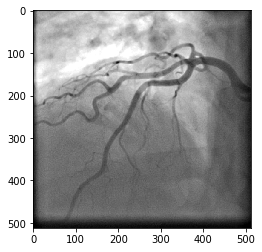

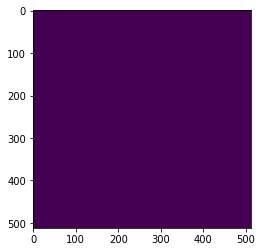

In [60]:
#@title Run on sample image (change IMAGE_URL to string output above) {display-mode: "form"}

IMAGE_URL = 'HL1024-2-26.png'  #@param {type:"string"}
#original_img = plt.imread(IMAGE_URL)
original_img = np.asarray(Image.open(IMAGE_URL).convert('L'))
preprocs_img = preprocess_input(original_img)
preprocs_img = np.expand_dims(preprocs_img, axis=-1)
preprocs_img = np.expand_dims(preprocs_img, axis=0)
print(preprocs_img.shape)

plt.figure()
plt.imshow(np.squeeze(original_img), cmap="gray")

inference = model.predict(preprocs_img)
print(inference.min())
print(inference.max())

sess = tf.Session()
full_sample = tf.nn.softmax(inference[0,:,:,:])
pred = tf.argmax(full_sample, axis=-1)
q = sess.run(pred)
print(q.min())
print(q.max())
q = q.astype('uint8')
plt.figure()
plt.imshow(q)